# Module 13 - Programming Assignment

## Directions

There are general instructions on Blackboard and in the Syllabus for Programming Assignments. This Notebook also has instructions specific to this assignment. Read all the instructions carefully and make sure you understand them. Please ask questions on the discussion boards or email me at `EN605.445@gmail.com` if you do not understand something.

<div style="background: mistyrose; color: firebrick; border: 2px solid darkred; padding: 5px; margin: 10px;">
You must follow the directions *exactly* or you will get a 0 on the assignment.
</div>

You must submit a zip file of your assignment and associated files (if there are any) to Blackboard. The zip file will be named after you JHED ID: `<jhed_id>.zip`. It will not include any other information. Inside this zip file should be the following directory structure:

```
<jhed_id>
    |
    +--module-01-programming.ipynb
    +--module-01-programming.html
    +--(any other files)
```

For example, do not name  your directory `programming_assignment_01` and do not name your directory `smith122_pr1` or any else. It must be only your JHED ID. Make sure you submit both an .ipynb and .html version of your *completed* notebook. You can generate the HTML version using:

> ipython nbconvert [notebookname].ipynb

or use the File menu.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv

## k Nearest Neighbors and Model Evaluation

You must complete the 4 following tasks:

1. Implement k-Nearest Neighbor *regression* as described in the Module.
2. Use validation curves as described in Module 9 to determine the best value of k trying values of 1 to 10. (You don't need to use odd values for regression). For this you can simply split the data randomly into a training and a test set with a 67/33 split.
3. Use learning curves as described in Module 9 to determine if your model could use more data.
    For this you can simply split the data randomly into a training and a test set with a 67/33 split. Use the best k from part 2.
4. Use 10-fold cross-validation to establish confidence bounds on your model's performance. Calculate the mean (average) MSE (which sounds funny, I know) and the standard deviation. 

Additionally, because you can't be *wrong* with the k = 1 in the training data, your curves will look a little funky initially.

As before make sure you actually plot curves and that everything is labeled. Each chart from part #2 and #3 has *two* curves. Please review the comments to Module 9 if you're not sure why.

Use the data in concrete_compressive_strength.csv for this assignment obtainable at [UCI ML Repository - Concrete Compressive Strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength).

Because the data is always the model, for knn, you simply need a function `knn` that will take the data, a value for k, and a List of instances and return a List of predictions (in this case, we're doing regression...you don't have to write a version of `knn` that would do either).

As before there's a lot of infrastructure involved and the specific names I leave up to you as long as you clearly indicate your answers to 1-4 above.

-----

## Helper Functions ##

**standardize(inD, classVar)**  
The function takes an input of a numpy recarray and a string indicating the variable which carries the class variable. It makes a deep copy of the input recarray and standardize all variable values except the class variable with: $$z_i = \frac{x_i - \bar{x}}{s_x}$$ where $z$ is the standardized value, $\bar{x}$ is the sample mean of $x$ ,and $s_x$ is the sample standard deviation of $x$.

**randomizedSplit(d, classVar, pct)**  
The function randomly shuffle the input recarray and split it into two numpy ndarrays containing the data of the parameter recarray. The column as indicated by the `classVar` parameter will be placed as the right-most column. The `pct` parameter determines what percentage of data goes to the first element of the output tuple, and the remaining to the second element (rounded to the nearest integer).

**plotRMSE(hyperParm, data, axisLabels=('',''))**  
The function plots the RMSE against an array as the `hyperParm` parameter. It is used to plot the validation and learning curve. A parameter signifying the legend of the plot is required. An optional input of `axisLabel` must have at least two elements where the first element will be graphed as the label of x axis and the second for y axis.

In [2]:
def standardize(inD, classVar):
    d = np.copy(inD)
    for v in d.dtype.names:
        if v == classVar: # do not standardize class variable
            continue
        d[v] = (d[v] - np.mean(d[v])) / np.std(d[v])
    return d

def randomizedSplit(d, classVar, pct):
    cols = [v for v in d.dtype.names if v != classVar] + [classVar]
    d = d[cols]
    d = np.array(d.tolist())

    idx = range(d.shape[0])
    np.random.shuffle(idx)
    split = int(round(d.shape[0] * pct))
    return d[idx[:split]], d[idx[split:]]

def plotRMSE(hyperParm, data, legends, axisLabels=('','')):
    if data.ndim == 1:
        data = np.expand_dims(data, axis=0)
    
    for n in range(data.shape[0]):
        plt.plot(hyperParm, data[n,:], label=legends[n])
    plt.legend(loc=0)
    plt.axis([0, max(hyperParm), -0, 20])
    plt.ylabel(axisLabels[1])
    plt.xlabel(axisLabels[0])
    plt.grid(b=True, which='major', color='k', linestyle=':')
    plt.show()
    return

def D(r1, r2):
    return np.sqrt(np.sum((r1-r2)**2, axis=1))

### Reading and splitting data ###
The data is read by the numpy function `recfromcsv` which reads a CSV file and naming the columns using the column headers. The data is standardized (except the class variable `strength`, and split into two numpy arrays where 67% goes to the training set and the rest to the testing set.

In [3]:
raw = np.recfromcsv('Concrete_Data.csv', delimiter=',', dtype='f8')
data = standardize(raw, 'strength')
(train, test) = randomizedSplit(data, 'strength', 0.67)

### K-Nearest Neighber Algorithm ###
**KNN(`data`, `toClass`, `k`, `majority=False`)**  
The function performs the main K-Nearest Neighbor algorithm. The function takes two numpy arrays: `data` is the training data used for classification purpose, and `toClass` is the data that the user wish to be classified. The third parameter, `majority`, is optional and when True, the algorithm takes the plurality of neighbor data point's classes by frequency. Otherwise, the algorithm returns a weighted average of all neighboring class values.

The function loops through the `toClass` array row by row (each row is a data point), calculates the euclidian distance of the current row against all rows of the training data (via vectorized numpy code), and takes the the `k` points with the smallest distance. For average of all k neighbor classes, the function uses the resulting distance as weight, where the predicted class $\hat{k}$ is calculated as:

$$\hat{k} = \sum_i^k{w_i x_i}, \quad w_i=\frac{1}{\epsilon + d_i}$$

where $d_i$ is the distance of the neighbor from the record to be classified. This gives more weighting to records in training data which are the closest to the record to be classified.

**evalKNN(pred, actual, numeric=True)**  
The function evaluates the predicted class against the actual class by either 
1. for numeric class, calculates the root mean-square error via: 
$$RMSE = \sqrt{\frac{1}{n}\sum_i^n{(\hat{k}-k)^2}}$$
1. for categorical class variable, calculates the error rate via:
$$\frac{1}{n}\sum_{i}^{n}{I_{k_i\ne\hat{k_i}}(i\in x)}$$

In [4]:
def KNN(data, toClass, k, majority=False):
    pred = np.zeros(toClass.shape[0])
    
    for n,t in enumerate(toClass):
        dist = np.sqrt(np.sum((t[:-1]-data[:,:-1])**2, axis=1))
        kInd = np.argpartition(dist, k)[:k]
        knn, kDist = data[kInd,-1], dist[kInd]
        
        if not majority:
            pred[n] = np.average(knn, weights=1/(1e-9 + kDist) )
        else:
            k, kN = np.unique(knn, return_counts=True)
            maxInd = np.argwhere(kN==np.amax(kN))
            if len(maxInd) > 1:
                maxInd = np.random.choice(maxInd, 1)
            pred[n] = k[maxInd]

    return pred

def evalKNN(pred, actual, numeric=True):
    if numeric:
        return np.linalg.norm(pred-actual)/np.sqrt(pred.size)
    else:
        return np.sum(pred==actual) / pred.size

### Validation Curve ###
The following code uses k from 1 to 15 and plots the validation curve of k against RMSE. While the RMSE is non-increasing wrt k, the marginal improvement is insignificant where k>8. Therefore k=8 is the best hyperparameter.

The k value with the lowest RMSE is 6


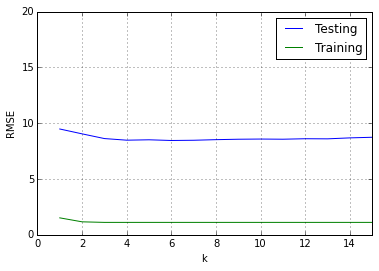

In [5]:
kList = range(1,16)
rmseVal = np.zeros([2,len(kList)])
for n,k in enumerate(kList):
    pred = KNN(train, test, k)
    rmseVal[0,n] = evalKNN(pred, test[:,-1])
    pred = KNN(train, train, k)
    rmseVal[1,n] = evalKNN(pred, train[:,-1])

kOpt = kList[np.argmin(rmseVal[0])]
print('The k value with the lowest RMSE is %u' %kOpt)
plotRMSE(kList, rmseVal, ['Testing', 'Training'], ('k','RMSE'))

---
### Learning Curve###

The following code calculates the RMSE necessary to plot a learning curve based on proportion of available training data used. The training data used is randomly assigned according to the proportion.

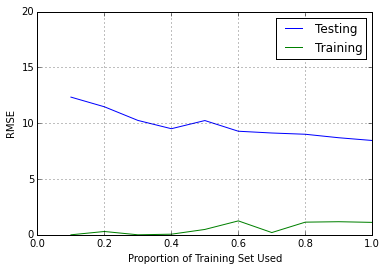

In [6]:
dsetSize = (np.arange(10)+1.0)/10
rmseLearn = np.zeros([2,len(dsetSize)])
for n,s in enumerate(dsetSize):
    idx = np.random.choice(train.shape[0], \
                           int(round(s*train.shape[0])) , replace=False)
    pred = KNN(train[idx,:], test, kOpt)
    rmseLearn[0,n] = evalKNN(pred, test[:,-1])
    
    pred = KNN(train[idx,:], train[idx,:], kOpt)
    rmseLearn[1,n] = evalKNN(pred, train[idx,:][:,-1])
    
plotRMSE(dsetSize, rmseLearn, ['Testing', 'Training'], \
         ('Proportion of Training Set Used','RMSE'))

### 10-fold cross-validation ###
The code splits the entirety of the shuffled data set into ten equally-sized chunks. Then it performs 10-fold leave-one out validation by using nine folds to train and the tenth for classification and evaluation. The average RMSE and the standard deviation is calculated.

In [7]:
slices = 10
whole = np.array(data.tolist())
rmseCross = np.zeros(len(dsetSize))
idx = np.arange(whole.shape[0])
np.random.shuffle(idx)
chunks = np.array_split(idx, slices)

for n in range(slices):
    selected = np.hstack([chunks[x] for x in range(slices) if x != n])
    nonselect = np.hstack([chunks[x] for x in range(slices) if x == n])
    pred = KNN(whole[selected,:], whole[nonselect,:], kOpt)
    rmseCross[n] = evalKNN(pred, whole[nonselect,-1])

print('Average RMSE is %f.'%np.mean(rmseCross))
print('Std Dev of RMSE is %f.'%np.std(rmseCross))

Average RMSE is 7.629606.
Std Dev of RMSE is 0.718746.
